In [16]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
np.random.seed(137)

# Load all necessary Data

In [17]:
object_trajectory=my_data = np.genfromtxt('/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/object_0_trajectory.csv', delimiter=',')
object_trajectory=object_trajectory[1:,:]
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
start_frame=round(object_trajectory[0,0])
end_frame=round(object_trajectory[-1,0])
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
koppenrath=Confectionery()
# load normal trajectories
normal_vector_trajectory=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/data/normal_vector_trajectory.npy")
rotation_trajectory=calculate_rotations_from_normal_vector_trajectory(normal_vector_trajectory)


# Caclulate Points to plot 

In [18]:
# number of frames
steps=100
#steps=object_trajectory.shape[0]-1
# interpolated points
N_intermediate=10
# interpolated time vector
t=np.linspace(0,1,N_intermediate)
# radius
radius=1
rotation_trajectory_matrix=[x.as_matrix() for x in rotation_trajectory.values()]
rotation_trajectory_matrix=np.array(rotation_trajectory_matrix)[:steps-1,:,:]
pts=normal_vector_trajectory[:,0].reshape((-1,3))
R_I=R.from_matrix(np.eye(3))
rots=np.concatenate((R_I.as_matrix().reshape((1,3,3)),rotation_trajectory_matrix[0,:,:].reshape((1,3,3))),axis=0)
rots=R.from_matrix(rots)
slerp=Slerp([0,1], rots)
interp_rots = slerp(t)
pts_new=interp_rots.apply(pts[-1,:])
pts=np.append(pts,pts_new,axis=0)
for i in range(1,steps-1):
    rots=np.concatenate((R_I.as_matrix().reshape((1,3,3)),rotation_trajectory_matrix[i,:,:].reshape((1,3,3))),axis=0)
    rots=R.from_matrix(rots)
    slerp=Slerp([0,1], rots)
    interp_rots = slerp(t)
    pts_new=interp_rots.apply(pts[-1,:])
    pts=np.append(pts,pts_new,axis=0)






# Plot Raw Trajectory

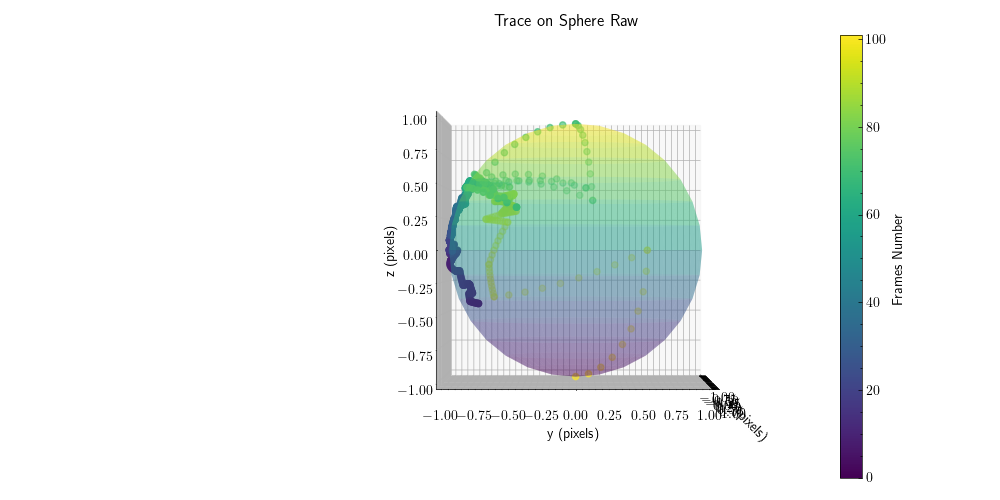

In [19]:
%matplotlib ipympl

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=radius
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
cmap = plt.get_cmap('viridis')
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title("Trace on Sphere Raw")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    sc=ax.scatter(pts[:,0],pts[:,1],pts[:,2], cmap=cmap,vmin=0,vmax=steps+1, c=np.linspace(0,steps+1,pts.shape[0]))
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')        
    cbar = plt.colorbar(sc, label='Frames Number')
    fig.tight_layout() 
plt.show()


# Trajectory Starting From Bottom

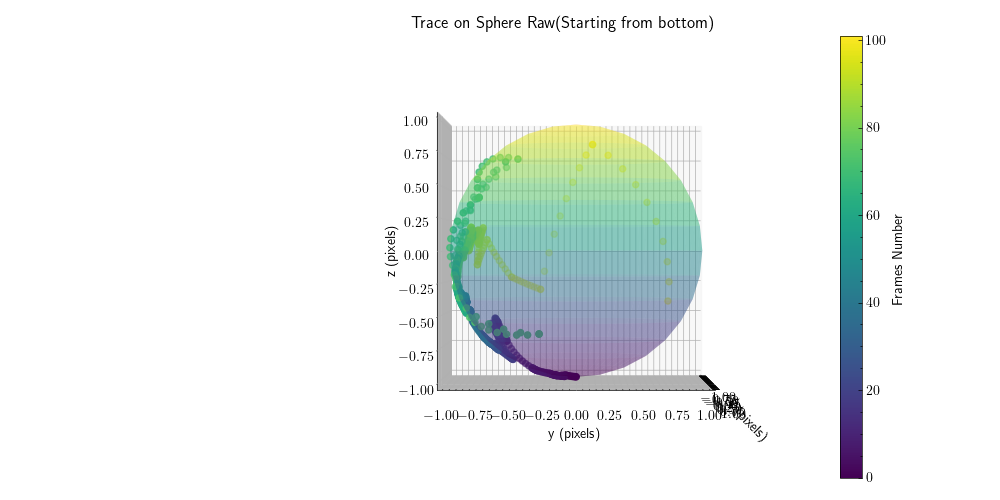

In [20]:
n_start=pts[0,:]
n_bottom=np.array([0,0,-1])
n_rot=np.cross(n_start,n_bottom)
if np.linalg.norm(n_start-n_bottom)<1e-6:
    R_bottom=R.from_matrix(np.eye(3))
elif np.linalg.norm(n_start+n_bottom)<1e-6:
    R_bottom=R.from_euler('x', np.pi)
else:
    angle_bottom=np.arctan2(np.linalg.norm(n_rot),np.dot(n_start,n_bottom))
    n_rot=n_rot/np.linalg.norm(n_rot)
    R_bottom=R.from_rotvec(n_rot*angle_bottom)
pts_bottom=R_bottom.apply(pts)

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=radius
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
cmap = plt.get_cmap('viridis')
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title("Trace on Sphere Raw(Starting from bottom)")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    sc=ax.scatter(pts_bottom[:,0],pts_bottom[:,1],pts_bottom[:,2], cmap=cmap,vmin=0,vmax=steps+1, c=np.linspace(0,steps+1,pts.shape[0]))
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')        
    cbar = plt.colorbar(sc, label='Frames Number')
    fig.tight_layout() 
plt.show()


# Plot trajectory and filter huge angle differences (set them to zero)

In [21]:
rotation_trajectory_filtered_rotvec=np.zeros((len(rotation_trajectory),3))
angle_thresh=np.pi/4
for i in range(len(rotation_trajectory)):
    if np.linalg.norm(rotation_trajectory[i].as_rotvec())<=angle_thresh:
        rotation_trajectory_filtered_rotvec[i,:]=rotation_trajectory[i].as_rotvec()
    else:
        rotation_trajectory_filtered_rotvec[i,:]=0
rotation_trajectory_filtered=R.from_rotvec(rotation_trajectory_filtered_rotvec)

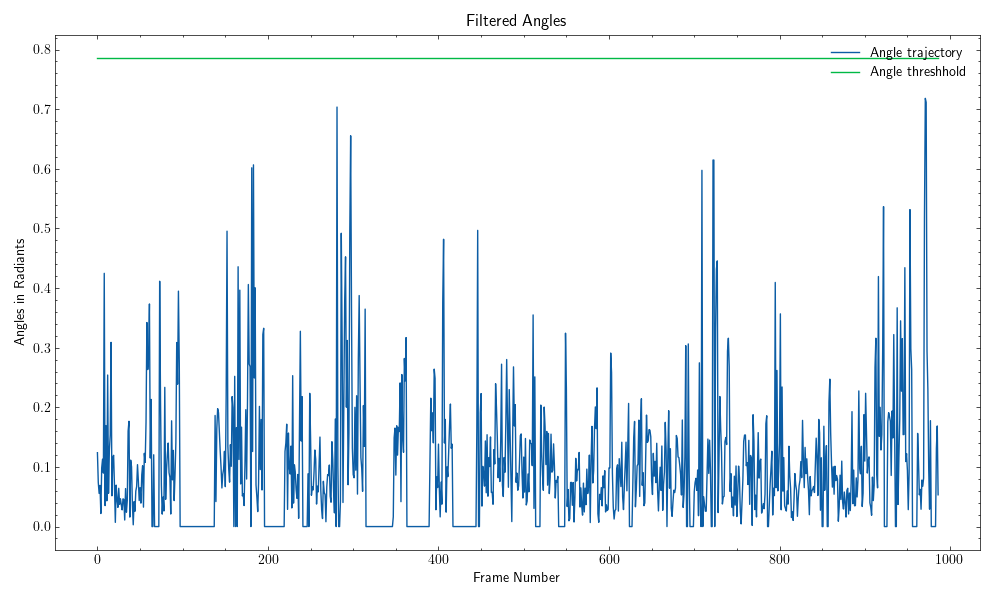

In [22]:
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("Filtered Angles")
    ax.set_xlabel("Frame Number")
    ax.set_ylabel("Angles in Radiants")
    ax.plot(np.arange(len(rotation_trajectory)),np.linalg.norm(rotation_trajectory_filtered_rotvec,axis=1), label="Angle trajectory")
    ax.plot(np.arange(len(rotation_trajectory)),angle_thresh*np.ones(len(rotation_trajectory)), label="Angle threshhold")
    ax.legend(loc="upper right")
plt.show()


In [23]:
rotation_trajectory_matrix=[x.as_matrix() for x in rotation_trajectory_filtered]
rotation_trajectory_matrix=np.array(rotation_trajectory_matrix)[:steps-1,:,:]
pts=normal_vector_trajectory[:,0].reshape((-1,3))
#pts=np.array([0,0,-1]).reshape((-1,3))

R_I=R.from_matrix(np.eye(3))
rots=np.concatenate((R_I.as_matrix().reshape((1,3,3)),rotation_trajectory_matrix[0,:,:].reshape((1,3,3))),axis=0)
rots=R.from_matrix(rots)
slerp=Slerp([0,1], rots)
interp_rots = slerp(t)
pts_new=interp_rots.apply(pts[-1,:])
pts=np.append(pts,pts_new,axis=0)
for i in range(1,steps-1):
    rots=np.concatenate((R_I.as_matrix().reshape((1,3,3)),rotation_trajectory_matrix[i,:,:].reshape((1,3,3))),axis=0)
    rots=R.from_matrix(rots)
    slerp=Slerp([0,1], rots)
    interp_rots = slerp(t)
    pts_new=interp_rots.apply(pts[-1,:])
    pts=np.append(pts,pts_new,axis=0)

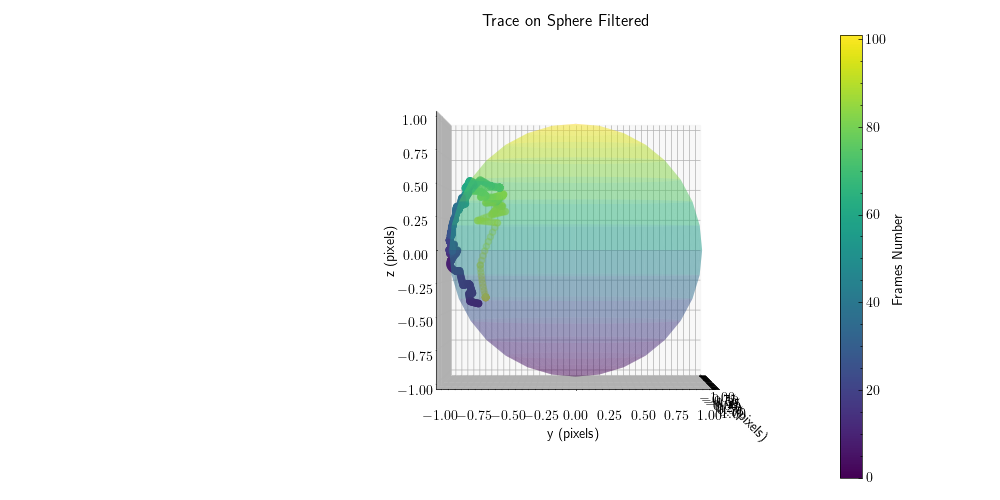

In [24]:
%matplotlib ipympl

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=radius
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
cmap = plt.get_cmap('viridis')
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title("Trace on Sphere Filtered")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    sc=ax.scatter(pts[:,0],pts[:,1],pts[:,2], cmap=cmap,vmin=0,vmax=steps+1, c=np.linspace(0,steps+1,pts.shape[0]))
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')        
    cbar = plt.colorbar(sc, label='Frames Number')
    fig.tight_layout() 
plt.show()

# Filtered Trajectory Starting From Bottom

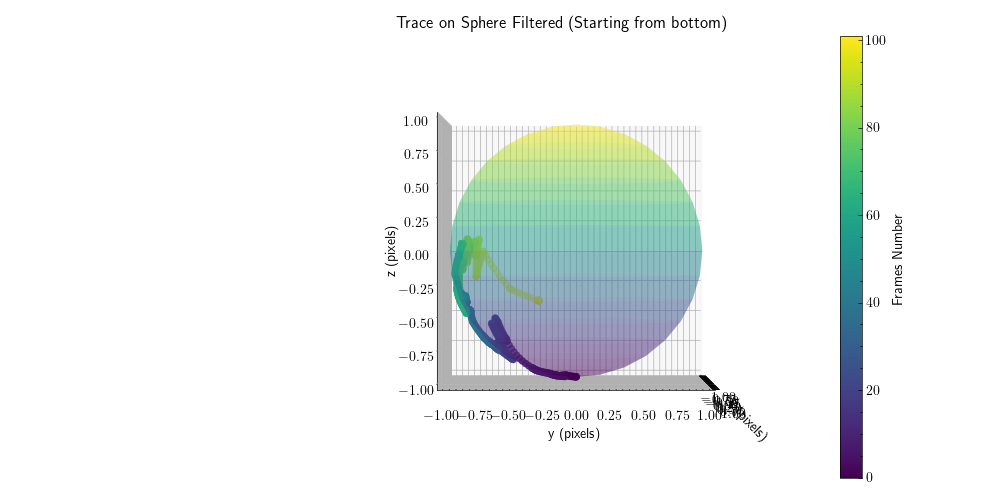

In [25]:
n_start=pts[0,:]
n_bottom=np.array([0,0,-1])
n_rot=np.cross(n_start,n_bottom)
if np.linalg.norm(n_start-n_bottom)<1e-6:
    R_bottom=R.from_matrix(np.eye(3))
elif np.linalg.norm(n_start+n_bottom)<1e-6:
    R_bottom=R.from_euler('x', np.pi)
else:
    angle_bottom=np.arctan2(np.linalg.norm(n_rot),np.dot(n_start,n_bottom))
    n_rot=n_rot/np.linalg.norm(n_rot)
    R_bottom=R.from_rotvec(n_rot*angle_bottom)
pts_bottom=R_bottom.apply(pts)

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=radius
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
cmap = plt.get_cmap('viridis')
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title("Trace on Sphere Filtered (Starting from bottom)")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    sc=ax.scatter(pts_bottom[:,0],pts_bottom[:,1],pts_bottom[:,2], cmap=cmap,vmin=0,vmax=steps+1, c=np.linspace(0,steps+1,pts.shape[0]))
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')        
    cbar = plt.colorbar(sc, label='Frames Number')
    fig.tight_layout() 
plt.show()

# Plot Raw Normal Vectors on Sphere

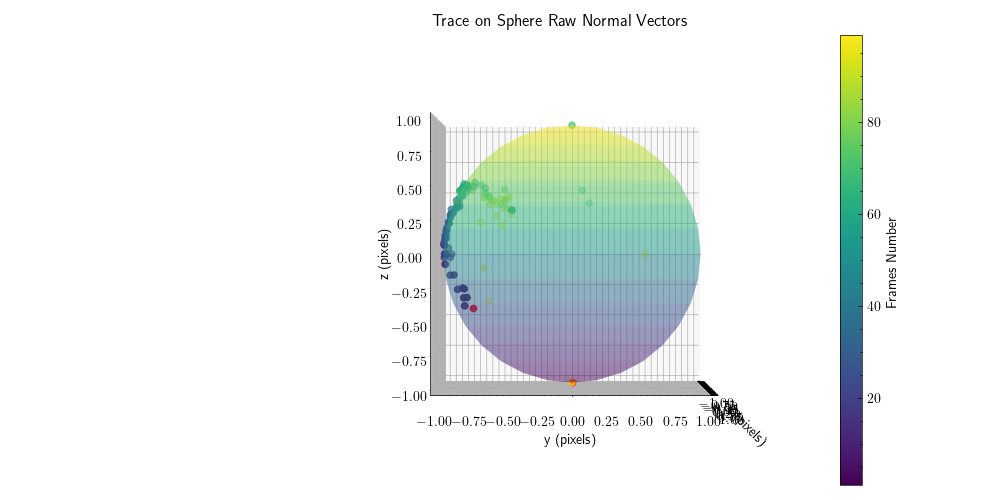

In [26]:
%matplotlib ipympl

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=radius
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
cmap = plt.get_cmap('viridis')
c=np.arange(1,steps)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title("Trace on Sphere Raw Normal Vectors")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    sc=ax.scatter(normal_vector_trajectory[0,1:steps],normal_vector_trajectory[1,1:steps],normal_vector_trajectory[2,1:steps], cmap=cmap,vmin=1, vmax=steps-1, c=c)
    ax.scatter(normal_vector_trajectory[0,0],normal_vector_trajectory[1,0],normal_vector_trajectory[2,0], color="red")
    ax.scatter(normal_vector_trajectory[0,steps],normal_vector_trajectory[1,steps],normal_vector_trajectory[2,steps], color="red")
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')        
    cbar = plt.colorbar(sc, label='Frames Number')
    fig.tight_layout() 
plt.show()

# Trajectory on Chart (Angles defined as Starting Point to End Point)

In [27]:
x_new=np.array([0,0,-1])
k=1
y_new=pts_bottom[-k,:]
while np.linalg.norm(x_new-y_new)<1e-6:
    k=k+1
    y_new=pts_bottom[-k,:]
y_new=y_new-np.dot(x_new,y_new)*x_new
y_new=y_new/np.linalg.norm(y_new)
# check if antiparralle y axis is better for chart
if np.sum(pts@y_new.reshape((3,1))<0)>pts.shape[0]/2:
    y_new=-y_new
z_new=np.cross(x_new,y_new)
R_new=np.array([x_new,y_new,z_new])
R_new=R.from_matrix(R_new)
pts_new=R_new.apply(pts_bottom)
phi=np.arctan2(pts_new[:,1],pts_new[:,0])
theta=np.arctan2(pts_new[:,2],np.sqrt(pts_new[:,0]**2+pts_new[:,1]**2))




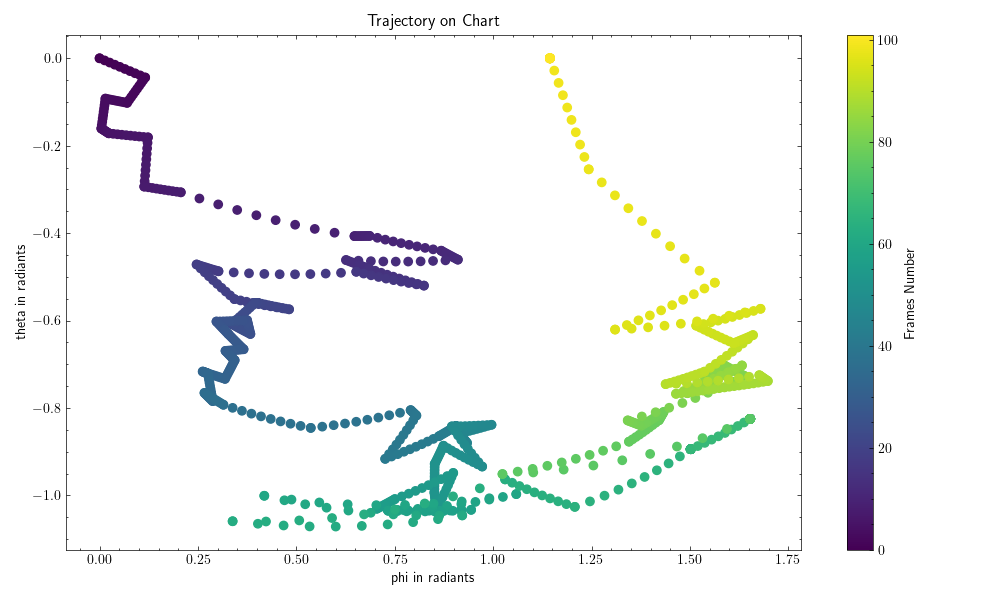

In [28]:
cmap = plt.get_cmap('viridis')
c=np.linspace(0,steps+1,phi.size)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title("Trajectory on Chart")
    ax.set_xlabel("phi in radiants")
    ax.set_ylabel("theta in radiants")
    sc=ax.scatter(phi,theta,cmap=cmap, c=c)
    cbar = plt.colorbar(sc, label='Frames Number')
plt.show()

# Ground Contact Trajectory

In [29]:
# number of frames
steps=100
#steps=object_trajectory.shape[0]-1
# interpolated points
N_intermediate=10
# interpolated time vector
t=np.linspace(0,1,N_intermediate)
# radius
radius=1
rotation_trajectory_matrix=[x.as_matrix() for x in rotation_trajectory.values()]
rotation_trajectory_matrix=np.array(rotation_trajectory_matrix)[:steps-1,:,:]
pts=np.array([0,0,1]).reshape((-1,3))
R_I=R.from_matrix(np.eye(3))
rots=np.concatenate((R_I.as_matrix().reshape((1,3,3)),rotation_trajectory_matrix[0,:,:].reshape((1,3,3))),axis=0)
rots=R.from_matrix(rots)
slerp=Slerp([0,1], rots)
interp_rots = slerp(t)
pts_new=interp_rots.apply(pts[-1,:])

pts=np.append(pts,pts_new,axis=0)

for i in range(1,steps-1):
    rots=np.concatenate((R_I.as_matrix().reshape((1,3,3)),rotation_trajectory_matrix[i,:,:].reshape((1,3,3))),axis=0)
    rots=R.from_matrix(rots)
    slerp=Slerp([0,1], rots)
    interp_rots = slerp(t)
    pts_new=interp_rots.apply(pts[-1,:])
    pts=np.append(pts,pts_new,axis=0)







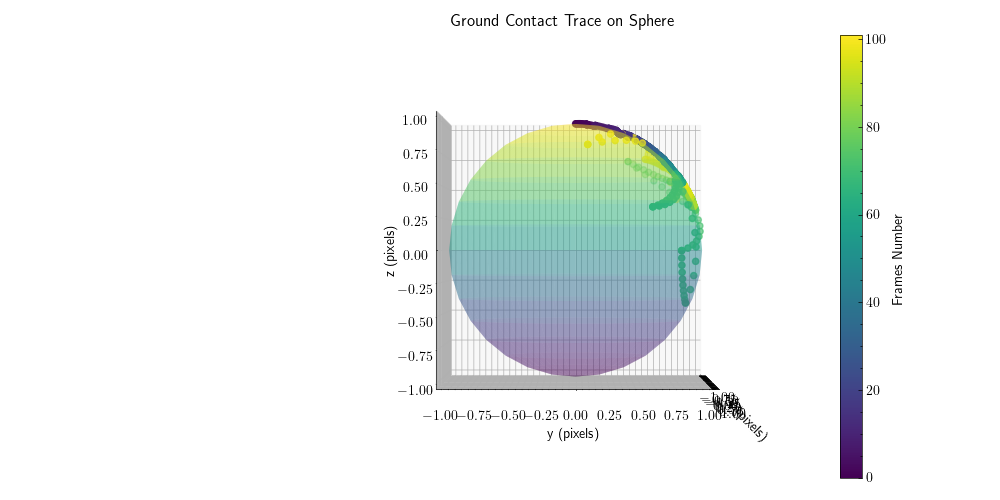

In [30]:
%matplotlib ipympl

u, v = np.meshgrid(np.linspace(0,2*np.pi,35),np.linspace(0,np.pi,17))
r=radius
x = r*np.cos(u) * np.sin(v)
y = r*np.sin(u) * np.sin(v)
z = r*np.cos(v)
cmap = plt.get_cmap('viridis')
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_title("Ground Contact Trace on Sphere")
    ax.plot_surface(x, y, z, alpha=0.3, cmap="viridis")
    sc=ax.scatter(pts[:,0],pts[:,1],pts[:,2], cmap=cmap,vmin=0,vmax=steps+1, c=np.linspace(0,steps+1,pts.shape[0]))
    ax.view_init(elev=0, azim=0, roll=0)
    ax.set_xlabel("x (pixels)")
    ax.set_ylabel("y (pixels)")
    ax.set_zlabel("z (pixels)")
    ax.axes.set_xlim3d(left=-r, right=r) 
    ax.axes.set_ylim3d(bottom=-r, top=r) 
    ax.axes.set_zlim3d(bottom=-r, top=r) 
    ax.set_aspect('equal', 'box')        
    cbar = plt.colorbar(sc, label='Frames Number')
    fig.tight_layout() 
plt.show()